## Calculate seasonal rainfall climatologies

Inputs: monthly CHIRPS 5km climatology tifs (https://www.chc.ucsb.edu/data/chpclim)
Outputs: 
- Congo basin dry and wet season 1km climatology (DJF, MAM, JJA, SON)
- Annual rainfall climatology
- Dry and wet season difference climatologies (JJA - DJF, and SON - MAM)
- Plots of all the above

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
#import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
import seaborn as sns

In [2]:
# suppress deprecated warnings
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
# suppress all warnings (only use this after the code is working correctly to make outputs easier to view)
warnings.filterwarnings("ignore")

In [3]:
# lake and river features to be added to maps
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='black')

lakes = cartopy.feature.NaturalEarthFeature(
    category='physical', name='lakes',
    scale='10m', facecolor='none', edgecolor='aqua')

In [4]:
WRKDIR = '/home/s0677837/Datastore/PHD/'
Chirps_clim = WRKDIR + 'CHIRPS/Clim_monthly/'
CHIRTS = WRKDIR + 'CHIRTS/'
PKL = WRKDIR + 'PKL/'

In [5]:
# full map extent (from full vegetation map extent) - this region will be extracted from the CHIRPS rainfall data
lat_min = -5.06319436
lat_max = 3.29741657
lon_min = 14.99769448
lon_max = 25.78052774

### Processing the CHIRPS climatology data into annual and seasonal accumulations

In [6]:
%%time
# reading in monthly CHIRPS climatology rainfall data

r_clim = []

for mo in range(1,13):
    mo = str(mo).zfill(2)
            
    # opening each image
    ds = xr.open_rasterio(Chirps_clim + 'chpclim.' + mo +'.tif')

    # renaming x and y dimensions to the same as the ALOS imagery
    ds = ds.rename({'x': 'longitude','y': 'latitude'})

    # cutting out to ALOS image size
    im = ds.where((lon_min < ds.longitude) & (ds.longitude < lon_max) & (lat_min < ds.latitude) & (ds.latitude < lat_max), drop=True)            

    # setting no values (currently -9999.0) to nan
    im = im.where(im != -9999., drop=True)   

    # converting from DataArray to Dataset format
    im = im.to_dataset(dim='band')
    
    # creating values and key pairs to rename the variables within the final concatenated array 
    # they are currently all labelled 1
    values = []
    values.append(mo)
    keys = im.keys()
    dictionary = dict(zip(keys, values))
    
    # changing the variable name to the month value
    im = im.rename_vars(dictionary)

    # appending each dekadal image to the array of all images
    r_clim.append(im)            


print (r_clim[1])


<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 3.275 3.225 3.175 ... -4.925 -4.975 -5.025
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    02         (latitude, longitude) float32 49.18 49.98 50.35 ... 160.5 159.0
Attributes: (12/15)
    transform:                 (0.05000000074505806, 0.0, -180.0, 0.0, -0.050...
    crs:                       +init=epsg:4326
    res:                       (0.05000000074505806, 0.05000000074505806)
    is_tiled:                  0
    nodatavals:                (nan,)
    scales:                    (1.0,)
    ...                        ...
    TIFFTAG_DOCUMENTNAME:      /home/ftp_out/products/FCLIM/monthly/fclim.02.tif
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.2.1, Exelis Visual Information Solutions...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRE

In [7]:
%%time
# concatenating the monthly data to 3 month seasonal data
DJF = r_clim[11]['12'] + r_clim[0]['01'] + r_clim[1]['02']
MAM = r_clim[2]['03'] + r_clim[3]['04'] + r_clim[4]['05']
JJA = r_clim[5]['06'] + r_clim[6]['07'] + r_clim[7]['08']
SON = r_clim[8]['09'] + r_clim[9]['10'] + r_clim[10]['11']
Annual = DJF + MAM + JJA + SON

DJF = DJF.to_dataset(name='DJF')
MAM = MAM.to_dataset(name='MAM')
JJA = JJA.to_dataset(name='JJA')
SON = SON.to_dataset(name='SON')
clim_chirps_annual = Annual.to_dataset(name='Annual')

clim_chirps_seasons = xr.merge([DJF,MAM,JJA,SON])

print(clim_chirps_seasons)

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 3.275 3.225 3.175 ... -4.925 -4.975 -5.025
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    DJF        (latitude, longitude) float32 138.8 142.1 146.3 ... 478.8 476.7
    MAM        (latitude, longitude) float32 465.3 465.5 469.1 ... 367.6 365.9
    JJA        (latitude, longitude) float32 439.6 441.9 439.9 ... 62.32 63.57
    SON        (latitude, longitude) float32 612.7 615.1 617.1 ... 422.8 422.2
CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 13.9 ms


### Plotting annual climatological rainfall data

In [8]:
def plot_map(ds,variable,cmap_name,label,t,b,l,r,vmin,vmax):
    # inputs: data array, variable, colour map, legend lable, plot ticks for top, bottom, left and right,cbar min, cbar max
    # e.g. plot_map(clim_chirps_annual,'Annual','viridis_r','Annual rainfall (mm)',True,True,True,True,0,2100)
    sns.set(font_scale=1.7, style="white")

    fig, ax = plt.subplots(
        nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},
                             figsize=(11.1, 9.4))
    ax.add_feature(rivers, linewidth=1)
    ax.add_feature(lakes, linewidth=1)
    lat_min = -5.03769436
    lat_max = 3.26980564
    ax.set_extent([15,23,-4, lat_max])
    cmap = plt.cm.get_cmap(cmap_name)
    im = ds[variable].plot(cmap=cmap,vmin=vmin,vmax=vmax,cbar_kwargs=dict(orientation='horizontal', pad=0.07,shrink=0.71,label=label))
    # adding 2nd axes labels
    
    for shape in footprint.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color='white')
    
    ax.tick_params(labeltop=True, labelright=True)

    labelsx=['0','16$^\circ$E','18$^\circ$E','20$^\circ$E','22$^\circ$E']
    #labelsx=['0','16$^\circ$E','18$^\circ$E','20$^\circ$E','22$^\circ$E','24$^\circ$E']
    ax.set_xticklabels(labelsx)
    ax.set_xlim(15,23)
    # turning off x and y label titles
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)

    y_axis = ax.axes.get_yaxis()
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    labelsy=['0','4$^\circ$S','3$^\circ$S','2$^\circ$S','1$^\circ$S','0$^\circ$','1$^\circ$N','2$^\circ$N','3$^\circ$N']
    #labelsy=['0','5$^\circ$S','4$^\circ$S','3$^\circ$S','2$^\circ$S','1$^\circ$S','0$^\circ$','1$^\circ$N','2$^\circ$N','3$^\circ$N']
    ax.set_yticklabels(labelsy)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right = r
    gl.xlines = True

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([16, 17, 18, 19, 20, 21, 22, 23])
    gl.ylocator = mticker.FixedLocator([-4,-3,-2,-1,0,1,2,3])
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    gl.xlabel_style = {'size': 15, 'color': 'black'}


    plt.show()    

In [9]:
# reading in the shapefile footprint (created within QGIS)
import shapefile as shp
footprint = shp.Reader(WRKDIR + '/Veg_maps/CC_footprint.shp')

In [10]:
clim_chirps_annual

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 3.275 3.225 3.175 ... -4.925 -4.975 -5.025
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    Annual     (latitude, longitude) float32 1.657e+03 1.665e+03 ... 1.328e+03

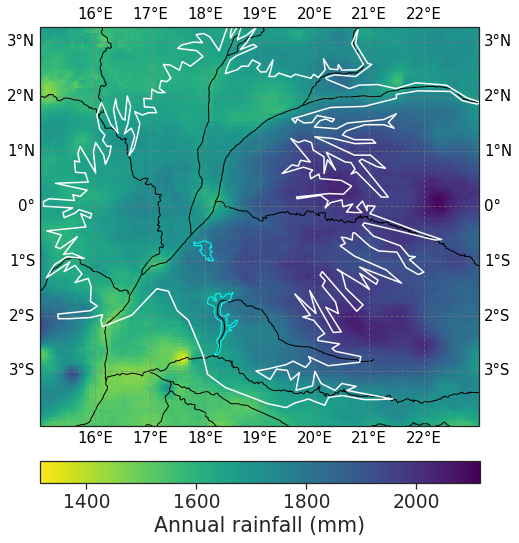

In [11]:
plot_map(clim_chirps_annual,'Annual','viridis_r','Annual rainfall (mm)',True,True,True,True,1315,2115)

### Plotting seasonal climatological rainfall data

In [12]:
def plot_map_seasons(ds,variable,cmap_name,label,t,b,l,r,vmin,vmax):
    # inputs: data array, variable, colour map, legend lable, plot ticks for top, bottom, left and right,cbar min, cbar max
    # e.g. plot_map(clim_chirps_annual,'Annual','viridis_r','Annual rainfall (mm)',True,True,True,True,0,2100)
    sns.set(font_scale=1.7, style="white")

    fig, ax = plt.subplots(
        nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},
                             figsize=(11.1*1.1, 9.4*1.1))
    ax.add_feature(rivers, linewidth=1)
    ax.add_feature(lakes, linewidth=1)

    lat_min = -5.03769436
    lat_max = 3.26980564
    ax.set_extent([15,23,-4, lat_max])
    cmap = plt.cm.get_cmap(cmap_name)
    im = ds[variable].plot(cmap=cmap,vmin=vmin,vmax=vmax,cbar_kwargs=dict(orientation='horizontal', pad=0.07,shrink=0.71,label=label))
    # adding 2nd axes labels
    ax.tick_params(labeltop=True, labelright=True)

    #labelsx=['0','16$^\circ$E','18$^\circ$E','20$^\circ$E','22$^\circ$E','24$^\circ$E']
    labelsx=['0','16$^\circ$E','18$^\circ$E','20$^\circ$E','22$^\circ$E']
    ax.set_xticklabels(labelsx)
    ax.set_xlim(15,23)
    # turning off x and y label titles
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)

    y_axis = ax.axes.get_yaxis()
    y_label = y_axis.get_label()
    y_label.set_visible(False)

    labelsy=['0','4$^\circ$S','3$^\circ$S','2$^\circ$S','1$^\circ$S','0$^\circ$','1$^\circ$N','2$^\circ$N','3$^\circ$N']
    #labelsy=['0','5$^\circ$S','4$^\circ$S','3$^\circ$S','2$^\circ$S','1$^\circ$S','0$^\circ$','1$^\circ$N','2$^\circ$N','3$^\circ$N']
    ax.set_yticklabels(labelsy)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right = r
    gl.xlines = True

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([16, 17, 18, 19, 20, 21, 22, 23])
    gl.ylocator = mticker.FixedLocator([-4,-3,-2,-1,0,1,2,3])
    gl.ylabel_style = {'size': 17, 'color': 'black'}
    gl.xlabel_style = {'size': 17, 'color': 'black'}


    plt.show()

In [13]:
clim_chirps_seasons

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 3.275 3.225 3.175 ... -4.925 -4.975 -5.025
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    DJF        (latitude, longitude) float32 138.8 142.1 146.3 ... 478.8 476.7
    MAM        (latitude, longitude) float32 465.3 465.5 469.1 ... 367.6 365.9
    JJA        (latitude, longitude) float32 439.6 441.9 439.9 ... 62.32 63.57
    SON        (latitude, longitude) float32 612.7 615.1 617.1 ... 422.8 422.2

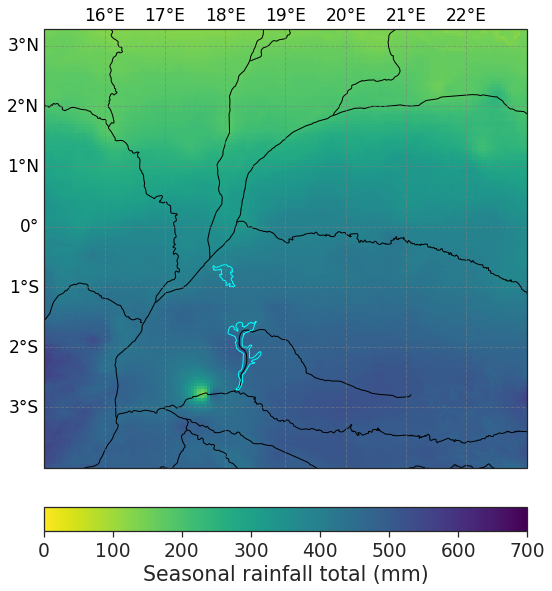

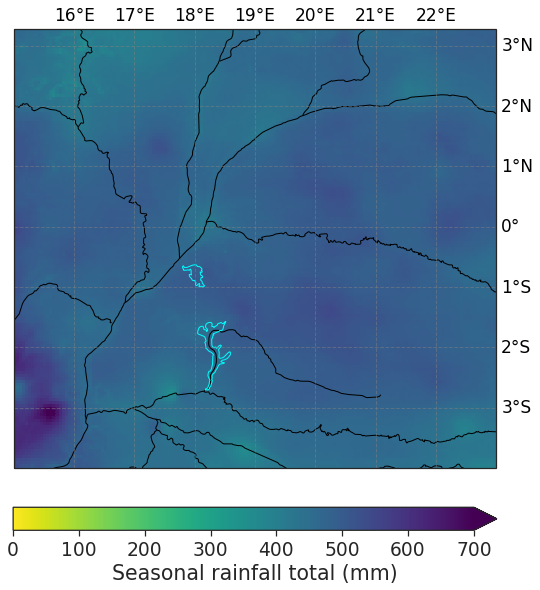

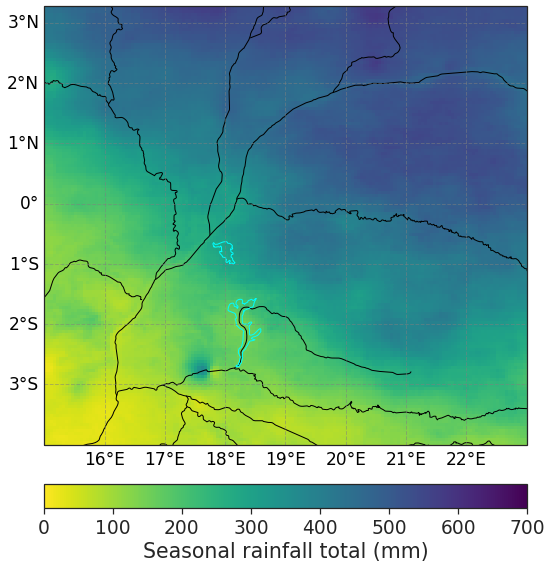

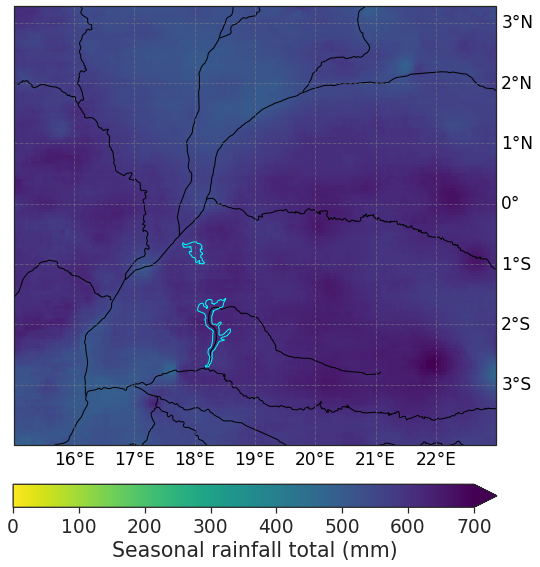

In [14]:
plot_map_seasons(clim_chirps_seasons,'DJF','viridis_r','Seasonal rainfall total (mm)',True,False,True,False,0,700)
plot_map_seasons(clim_chirps_seasons,'MAM','viridis_r','Seasonal rainfall total (mm)',True,False,False,True,0,700)
plot_map_seasons(clim_chirps_seasons,'JJA','viridis_r','Seasonal rainfall total (mm)',False,True,True,False,0,700)
plot_map_seasons(clim_chirps_seasons,'SON','viridis_r','Seasonal rainfall total (mm)',False,True,False,True,0,700)

### Plotting monthly rainfall climatology data

In [15]:
# concatenating monthly data for plotting 4 * 3 monthly clim (starting with Dec)
clim_chirps_months = xr.merge([r_clim[11]['12'],r_clim[0]['01'],r_clim[1]['02'],r_clim[2]['03'],r_clim[3]['04'],r_clim[4]['05'],r_clim[5]['06'],r_clim[6]['07'],r_clim[7]['08'],r_clim[8]['09'],r_clim[9]['10'],r_clim[10]['11']])

In [16]:
#clim_chirps_months
keys = clim_chirps_months.keys()
values = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov']
print (keys)

dictionary2 = dict(zip(keys, values))
    
# changing the variable name to the month value
clim_chirps_months = clim_chirps_months.rename_vars(dictionary2)

KeysView(<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 3.275 3.225 3.175 ... -4.925 -4.975 -5.025
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    12         (latitude, longitude) float32 59.25 61.0 63.19 ... 158.7 157.7
    01         (latitude, longitude) float32 30.42 31.15 32.7 ... 159.6 160.1
    02         (latitude, longitude) float32 49.18 49.98 50.35 ... 160.5 159.0
    03         (latitude, longitude) float32 140.7 141.2 142.8 ... 156.7 155.5
    04         (latitude, longitude) float32 161.9 161.4 163.0 ... 155.7 155.7
    05         (latitude, longitude) float32 162.8 162.9 163.3 ... 55.21 54.68
    06         (latitude, longitude) float32 154.0 151.9 151.5 ... 5.52 5.152
    07         (latitude, longitude) float32 119.3 123.8 122.1 ... 7.808 7.777
    08         (latitude, longitude) float32 166.2 166.2 166.3 ... 48.99 50.64
    09         (latitude, longit

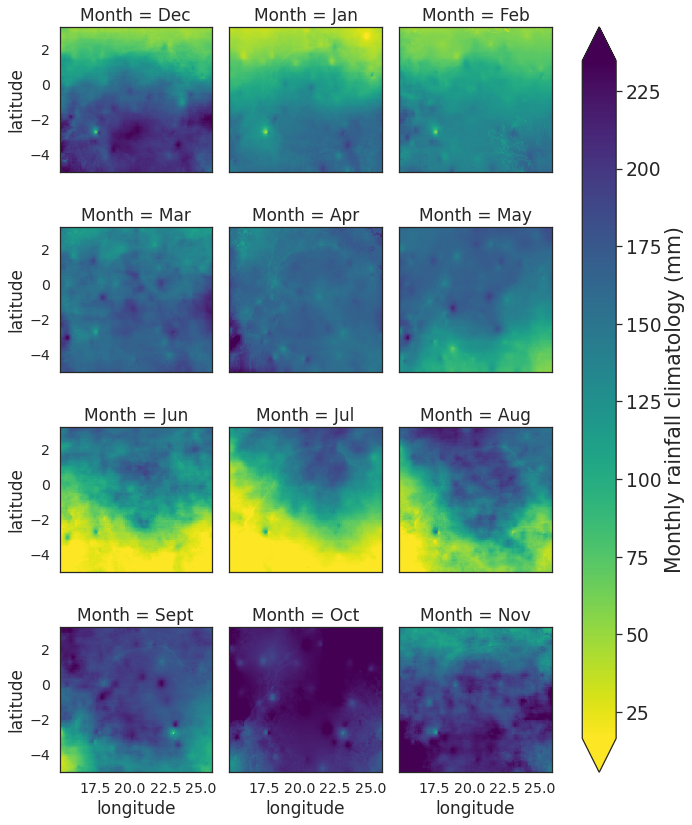

In [17]:
# ploting monthly rainfall climatology

months_array = clim_chirps_months.to_array()
months_array = months_array.rename({'variable':'Month'})

ax = months_array.plot(x='longitude',y='latitude',col='Month',col_wrap=3,cmap='viridis_r', robust=True, cbar_kwargs={"label": "Monthly rainfall climatology (mm)"},)
ax.set_ticks(fontsize='x-small')
ax.set_titles(fontsize='small')
ax.set_xlabels(fontsize='small')
ax.set_ylabels(fontsize='small')

In [18]:
# interpolate to same grid as the vegetation (currently 250m)
# interpolating to 250m grid (the grid is currently too big to perform calculations over)
# current grid spacing is 0.00044444 for lat and long
#shift = 0.0255  # upscaling vegetation map slightly, so no shift required.
#ds_out_250m = xr.Dataset({'lat': (['latitude'], np.arange(lat_min + shift, lat_max - shift, 0.0025)),
#                     'lon': (['longitude'], np.arange(lon_min + shift, lon_max - shift, 0.0025)),
#                    }
#                   )
#ds_out_250m


# alternative 1km grid
shift = 0.0  # upscaling vegetation map slightly, so no shift required.
ds_out_1km = xr.Dataset({'lat': (['latitude'], np.arange(lat_min + shift, lat_max - shift, 0.01)),
                     'lon': (['longitude'], np.arange(lon_min + shift, lon_max - shift, 0.01)),
                        })
ds_out_1km

<xarray.Dataset>
Dimensions:  (latitude: 837, longitude: 1079)
Dimensions without coordinates: latitude, longitude
Data variables:
    lat      (latitude) float64 -5.063 -5.053 -5.043 ... 3.277 3.287 3.297
    lon      (longitude) float64 15.0 15.01 15.02 15.03 ... 25.76 25.77 25.78

In [19]:
%%time
# creating the new grid to be applied to all of the data within the CHIRPS array at 0.1 degrees resolution (~1.11 km) 
# 50 m version is too slow
# Bilinear interpolation used
regridder = xe.Regridder(clim_chirps_seasons['DJF'], ds_out_1km, 'bilinear')
regridder  # print basic regridder information.

CPU times: user 14.2 s, sys: 1.1 s, total: 15.3 s
Wall time: 15.3 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_167x216_837x1079.nc 
Reuse pre-computed weights? False 
Input grid shape:           (167, 216) 
Output grid shape:          (837, 1079) 
Periodic in longitude?      False

In [20]:
%%time
# regridding the chirps climatology map to 0.01 degrees
clim_chirps_final = regridder(clim_chirps_seasons[['DJF','MAM','JJA','SON']])
clim_chirps_final

CPU times: user 29 ms, sys: 0 ns, total: 29 ms
Wall time: 27.8 ms


<xarray.Dataset>
Dimensions:  (latitude: 837, longitude: 1079)
Coordinates:
    lon      (longitude) float64 15.0 15.01 15.02 15.03 ... 25.76 25.77 25.78
    lat      (latitude) float64 -5.063 -5.053 -5.043 ... 3.277 3.287 3.297
Dimensions without coordinates: latitude, longitude
Data variables:
    DJF      (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MAM      (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    JJA      (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SON      (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [21]:
# renaming latitude and longitude to lat and lon
clim_chirps_final = clim_chirps_final.rename({'longitude': 'lon','latitude': 'lat'})

In [22]:
clim_chirps_final

<xarray.Dataset>
Dimensions:  (lat: 837, lon: 1079)
Coordinates:
  * lon      (lon) float64 15.0 15.01 15.02 15.03 ... 25.75 25.76 25.77 25.78
  * lat      (lat) float64 -5.063 -5.053 -5.043 -5.033 ... 3.277 3.287 3.297
Data variables:
    DJF      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MAM      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    JJA      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SON      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

### Calculating and plotting dry and wet season differences 
- JJA - DJF and JJA/DJF
- SON - MAM and SON/MAM

In [23]:
# Calculating wet and dry season differences
clim_chirps_diff = clim_chirps_final.copy()
clim_chirps_diff['JJA - DJF (mm)'] = clim_chirps_diff['JJA'] - clim_chirps_diff['DJF']
clim_chirps_diff['SON - MAM (mm)'] = clim_chirps_diff['SON'] - clim_chirps_diff['MAM']
clim_chirps_diff['JJA : DJF'] = clim_chirps_diff['JJA'] / clim_chirps_diff['DJF']
clim_chirps_diff['SON : MAM'] = clim_chirps_diff['SON'] / clim_chirps_diff['MAM']

In [24]:
def plot_differences(df):
    # function to plot the difference or ratios between the two dry or two wet seasons
    sns.set(font_scale=1.7, style="white")

    fig, ax = plt.subplots(
        nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},
                             figsize=(11.1, 9.4))
    ax.add_feature(rivers, linewidth=1)
    ax.add_feature(lakes, linewidth=1)
    lat_min = -5.03769436
    lat_max = 3.26980564
    ax.set_extent([15,23,-4, lat_max])
    cmap = plt.cm.get_cmap('RdBu')
    im = df.plot(cmap=cmap,cbar_kwargs=dict(orientation='horizontal', pad=0.07,shrink=0.71,label='SON - MAM rainfall (mm)'))
    #ax.plot(data=footprint, pen=["0.02c", 'white'])

    for shape in footprint.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x,y, color='white')


    # adding 2nd axes labels
    ax.tick_params(labeltop=True, labelright=True)

    labelsx=['0','16$^\circ$E','18$^\circ$E','20$^\circ$E','22$^\circ$E']
    ax.set_xticklabels(labelsx)
    ax.set_xlim(15,23)
    # turning off x and y label titles
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)

    y_axis = ax.axes.get_yaxis()
    y_label = y_axis.get_label()
    y_label.set_visible(False)


    labelsy=['0','4$^\circ$S','3$^\circ$S','2$^\circ$S','1$^\circ$S','0$^\circ$','1$^\circ$N','2$^\circ$N','3$^\circ$N']
    ax.set_yticklabels(labelsy)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = True
    gl.ylabels_left = True
    gl.xlines = True

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([16, 17, 18, 19, 20, 21, 22, 23])
    gl.ylocator = mticker.FixedLocator([-4,-3,-2,-1,0,1,2,3])
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    gl.xlabel_style = {'size': 15, 'color': 'black'}


    plt.show()

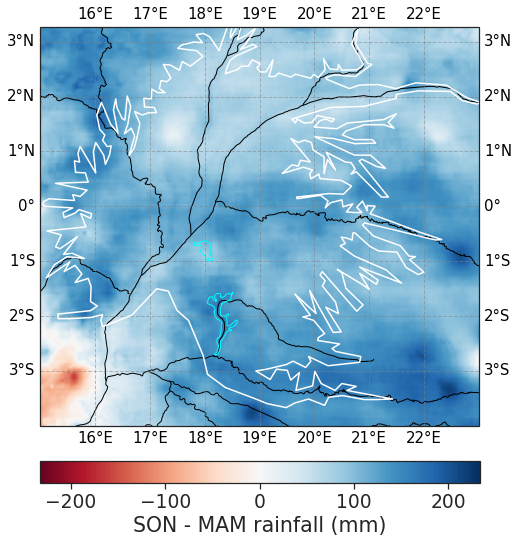

In [25]:
# Plotting wet season differences (2nd - 1st wet season)
plot_differences(clim_chirps_diff['SON - MAM (mm)'])

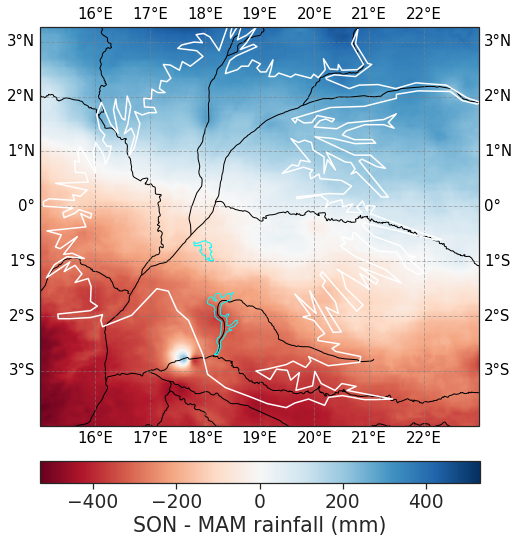

In [26]:
# Plotting dry season differences (2nd - 1st dry season)
plot_differences(clim_chirps_diff['JJA - DJF (mm)'])